## Loading the libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# from keras.models import Model
# from keras.layers import Input, Reshape, Dot
# from keras.layers.embeddings import Embedding
# from keras.optimizers import Adam
# from keras.regularizers import l2
# from keras.layers import Concatenate, Dense, Dropout
# from keras.layers import Add, Activation, Lambda

import tensorflow as tf
import keras
from pprint import pprint

In [3]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [4]:
# !wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

Archive:  ml-100k.zip


#Loading MovieLens dataset

Loading u.info -- The number of users, items, and ratings in the u data set.

In [5]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("Details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))

Details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


Loading u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.

---



              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC 

In [6]:
## same item id is same as movie id, item id column is renamed as movie id
column_names1 = ['user id','movie id','rating','timestamp']
ratings_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
ratings_dataset.head() 

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Loading u.item     -- Information about the items (movies); this is a tab separated

              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.


In [7]:
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
print(column_names2)

['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [8]:
items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column

In [10]:
## looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column
len(items_dataset.groupby(by=column_names2[1:])),len(items_dataset)

(1664, 1682)

We can see there are 18 extra movie id's for already mapped movie title and the same duplicate movie id is assigned to the user in the user-item dataset.

#Merging required datasets

In [11]:
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()

,user id,movie id,rating,timestamp,movie title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


A dataset is created from the existing merged dataset by grouping the unique user id and movie title combination and the ratings by a user to the same movie in different instances (timestamps) are averaged and stored in the new dataset.

Example of a multiple rating scenario by an user to a specific movie:

In [12]:
merged_dataset[(merged_dataset['movie title'] == 'Chasing Amy (1997)') & (merged_dataset['user id'] == 894)]

,user id,movie id,rating,timestamp,movie title
62716,894,246,4,882404137,Chasing Amy (1997)
90596,894,268,3,879896041,Chasing Amy (1997)


## Creating a final refined dataset with unique user id, movie name combination and their ratings:


In [13]:
refined_dataset = merged_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


## Encoding users and movie titles to make sure that the sequence has no missing values when dealing with Deep Neural Networks.

In [14]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user id'].values)
n_users = refined_dataset['user'].nunique()

In [15]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['movie title'].values)
n_movies = refined_dataset['movie'].nunique()

In [16]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(943, 1664, 1.0, 5.0)

In [17]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


## Splitting the data into training and testing

In [18]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89723, 2), (9970, 2), (89723,), (9970,))

## Defining number of factors which are to be considered by the Embedding layer

In [19]:
n_factors = 150

Columns in the input array are split into two separate arrays. As Keras considers them as two distinct inputs, each input needs to be fed in as its own array.

In [20]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [21]:
X_train, X_train_array, X_train_array[0].shape

(array([[ 180, 1152],
        [ 487,  389],
        [ 177,  302],
        ...,
        [ 431, 1588],
        [ 232,  399],
        [ 138,  612]], dtype=int64),
 [array([180, 487, 177, ..., 431, 232, 138], dtype=int64),
  array([1152,  389,  302, ..., 1588,  399,  612], dtype=int64)],
 (89723,))

## Normalizing the labels

In [22]:

y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

## Building a Softmax Deep Neural Network

In [24]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [25]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 150)            │         141,450 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 1, 150)            │         249,600 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 150)               │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape_1 (Reshape)           │ (None, 150)               │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 300)               │               0 │ reshape[0][0],             │
│                               │                           │                 │ reshape_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 300)               │               0 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 32)                │           9,632 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 32)                │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 32)                │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 16)                │             528 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 16)                │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 16)                │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 9)                 │             153 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 9)                 │               0 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 401,363 (1.53 MB)

 Trainable params: 401,363 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])


Epoch 1/70
701/701 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0624 - loss: 1.2388 - val_accuracy: 0.0617 - val_loss: 0.5276 - learning_rate: 0.0100
Epoch 2/70
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0602 - loss: 0.5357 - val_accuracy: 0.0617 - val_loss: 0.5145 - learning_rate: 0.0100
Epoch 3/70
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0592 - loss: 0.5267 - val_accuracy: 0.0617 - val_loss: 0.5114 - learning_rate: 0.0100
Epoch 4/70
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0603 - loss: 0.5240 - val_accuracy: 0.0617 - val_loss: 0.5097 - learning_rate: 0.0100
Epoch 5/70
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0611 - loss: 0.5230 - val_accuracy: 0.0617 - val_loss: 0.5088 - learning_rate: 0.0100
Epoch 6/70
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0615 - loss: 0.5200 - val_accuracy: 0.0617 - val_loss: 0.5072 - learning_rate: 0.0100
Epoch 7/70
701/701 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0605 - loss: 0.5174 - 

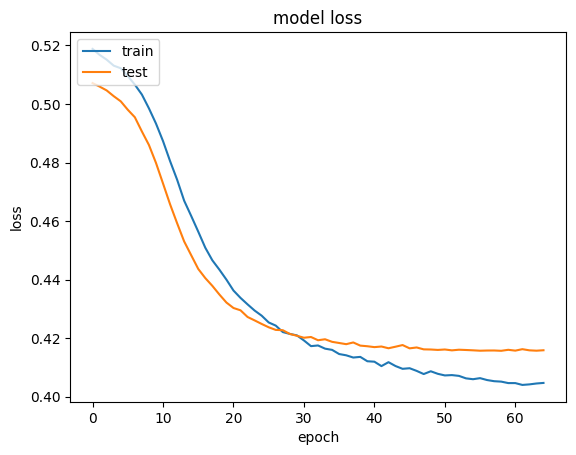

In [27]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Getting movies for given User

In [28]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


**How this DNN model works is, it takes two inputs, one of the input has user id's and the other has corresponding movie id's. Here DNN model tries to predict the ratings of the user - movie combination. So, we can input a specific user id (broadcasting it with the size of other input) and unseen movie id of the user and expect the model to give the ratings of the movies which would have been the ratings given by the user. Here, the ratings are already normalized and as we need the movies which interest the user more, ratings are not brought back to 0-5 scale.**

In [29]:
X_train_array

[array([180, 487, 177, ..., 431, 232, 138], dtype=int64),
 array([1152,  389,  302, ..., 1588,  399,  612], dtype=int64)]

Above is the model input shape

In [30]:

user_id = [777]
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id[0]]['movie'])
print(seen_movies)

[7, 55, 87, 113, 313, 337, 389, 390, 399, 411, 432, 460, 498, 528, 580, 604, 612, 643, 666, 783, 996, 1005, 1032, 1102, 1132, 1157, 1190, 1208, 1251, 1260, 1284, 1302, 1342, 1523, 1558, 1615]


Id's of movies which are already seen by the user are extracted.

In [31]:
len(refined_dataset['movie'].unique()), min(refined_dataset['movie']), max(refined_dataset['movie'])

(1664, 0, 1663)

We can understand that the labels are from 0 to 1663. So the movie id's which are not seen by the user can be pciked just by excluding the 'seen_movies' list from the first 1663 natural numbers.

In [32]:
unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
print(unseen_movies)

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 

Movies which are not seen by the user.

In [33]:
len(unseen_movies) + len(seen_movies)

1664

In [34]:
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
len(model_input), len(model_input[0])

(2, 1628)

**DNN model is used to predict the ratings of the unseen movies.**

In [35]:
predicted_ratings = model.predict(model_input)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [36]:
print(predicted_ratings.shape)

(1628, 9)


In [37]:
print(predicted_ratings)

[[5.8408582e-01 4.1572022e-01 2.8086306e-05 ... 2.3730367e-05
  1.7543909e-05 2.2751514e-05]
 [5.5394608e-01 4.4588244e-01 2.5007148e-05 ... 2.0010981e-05
  1.4699386e-05 2.0199670e-05]
 [8.8058847e-01 1.1923005e-01 2.5746640e-05 ... 2.4962283e-05
  1.8961817e-05 1.9970210e-05]
 ...
 [6.1107403e-01 3.8875192e-01 2.4664416e-05 ... 2.1367656e-05
  1.6009586e-05 1.9550029e-05]
 [5.2993584e-01 4.6989888e-01 2.4147481e-05 ... 1.8898161e-05
  1.4192525e-05 1.9261652e-05]
 [4.9048063e-01 5.0924879e-01 4.1609364e-05 ... 2.9589342e-05
  2.2412898e-05 3.2551350e-05]]


Output is of shape (1628, 9). We got probability of each possible rating from 1 to 5. We can extract specific rating which user would have given to a movie but it is not useful for these recommendations now.

In [38]:
predicted_ratings = np.max(predicted_ratings, axis=1)
predicted_ratings

array([0.5840858 , 0.5539461 , 0.8805885 , ..., 0.61107403, 0.52993584,
       0.5092488 ], dtype=float32)

In [39]:
predicted_ratings.shape

(1628,)

Index of ratings sorted by descending order.

In [40]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)

[1445  135  962 ... 1182 1023  832]


**Movie names have been extracted from the available indices we got.**

In [41]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies

array(['Sword in the Stone, The (1963)', 'Baton Rouge (1988)',
       'Meet Wally Sparks (1997)', ..., 'Private Parts (1997)',
       "Muriel's Wedding (1994)", 'Lamerica (1994)'], dtype=object)

## Movies recommended with the help of Softmax Deep Neural Networks

In [42]:
from pprint import pprint
pprint(list(recommended_movies[:20]))

['Sword in the Stone, The (1963)',
 'Baton Rouge (1988)',
 'Meet Wally Sparks (1997)',
 'In the Line of Duty 2 (1987)',
 'Conspiracy Theory (1997)',
 'Red Firecracker, Green Firecracker (1994)',
 'Getaway, The (1994)',
 'Striking Distance (1993)',
 'Saint, The (1997)',
 'Two or Three Things I Know About Her (1966)',
 'Diva (1981)',
 'Stand by Me (1986)',
 'Grosse Fatigue (1994)',
 'Jaws 2 (1978)',
 'Bride of Frankenstein (1935)',
 'Welcome to the Dollhouse (1995)',
 'Ballad of Narayama, The (Narayama Bushiko) (1958)',
 'This Is Spinal Tap (1984)',
 'Bonnie and Clyde (1967)',
 'Cemetery Man (Dellamorte Dellamore) (1994)']


## Summing up the entire code into a recommender system function:

In [43]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

In [45]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)


Enter user id


 10


Enter number of movies to be recommended:


 25



Movie seen by the User:
['12 Angry Men (1957)',
 '2001: A Space Odyssey (1968)',
 '39 Steps, The (1935)',
 'Abyss, The (1989)',
 'African Queen, The (1951)',
 'Alice in Wonderland (1951)',
 'Alien (1979)',
 'Aliens (1986)',
 'All About Eve (1950)',
 'Amadeus (1984)',
 'American President, The (1995)',
 'American in Paris, An (1951)',
 'Apocalypse Now (1979)',
 'Around the World in 80 Days (1956)',
 'Bad Moon (1996)',
 'Bananas (1971)',
 'Barcelona (1994)',
 'Basketball Diaries, The (1995)',
 'Beauty and the Beast (1991)',
 'Being There (1979)',
 'Better Off Dead... (1985)',
 'Big Night (1996)',
 'Big Sleep, The (1946)',
 'Blue Angel, The (Blaue Engel, Der) (1930)',
 'Blues Brothers, The (1980)',
 'Bonnie and Clyde (1967)',
 'Boogie Nights (1997)',
 'Bound (1996)',
 'Braveheart (1995)',
 'Brazil (1985)',
 'Breaking the Waves (1996)',
 'Bridge on the River Kwai, The (1957)',
 'Bridges of Madison County, The (1995)',
 'Bringing Up Baby (1938)',
 'Bronx Tale, A (1993)',
 'Browning Version

# Rough Work

In [46]:
a = np.asarray([[2,3,14,6],[3,5,7,2],[6,8,4,1]])
a, a.shape

(array([[ 2,  3, 14,  6],
        [ 3,  5,  7,  2],
        [ 6,  8,  4,  1]]),
 (3, 4))

In [47]:
b=np.max(a, axis=1)
b, b.shape

(array([14,  7,  8]), (3,))

In [48]:
np.argsort(b)[::-1]

array([0, 2, 1], dtype=int64)

In [49]:

user_enc.transform([1])

array([0], dtype=int64)

In [50]:
max(refined_dataset['user'])

942